In [1]:
!pip install numpy matplotlib pandas tqdm


[notice] A new release of pip is available: 23.1.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import json

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
with open("metrics.json", encoding="utf-8") as f:
    metrics = json.load(f)

In [4]:
pd.set_option('display.max_rows', 30)

float_tests = [{"size": v["size"],**v["tests"][0]} for v in metrics if v["type"] == "float" and "size" in v]
float_tests_df = pd.DataFrame(float_tests)
float_tests_df = float_tests_df.sort_values("duration", ascending=True)

double_tests = [{"size": v["size"],**v["tests"][0]} for v in metrics if v["type"] == "double" and "size" in v]
double_tests_df = pd.DataFrame(double_tests)
double_tests_df = double_tests_df.sort_values("duration", ascending=True)

In [5]:
double_tests_df[double_tests_df["size"] == 10**8].sort_values("duration")

,size,duration,result,runtime
18,100000000,7.759000,3.333246e+07,OpenCL
72,100000000,7.888400,3.333106e+07,OpenCL
396,100000000,7.895100,3.333528e+07,OpenCL
234,100000000,7.910201,3.334016e+07,OpenCL
126,100000000,7.932700,3.332936e+07,OpenCL
...,...,...,...,...
270,100000000,105.769508,3.333043e+07,OpenMP
54,100000000,106.156708,3.333268e+07,OpenMP
108,100000000,107.860306,3.333589e+07,OpenMP
486,100000000,112.539902,3.333425e+07,OpenMP


In [6]:
def plot_metrics(metrics_df):
    markers = ["o", "s", "^", "D"]
    items = metrics_df.groupby("runtime")

    for i, (runtime, group) in enumerate(items):
        group = group.groupby("size", as_index=False).mean(numeric_only=True)
        group = group[group["size"] >= 10**3]
        
        plt.plot(group["size"],
                 group["duration"],
                #  linestyle='',
                 marker=markers[i % len(markers)],
                 markersize=7,
                 label=runtime)

    plt.ticklabel_format(axis="x", style="sci", scilimits=(0, 0)) 
    plt.xscale("log")
    plt.xlabel("N", labelpad=2)
    plt.ylabel("t,ms", labelpad=2)
    plt.legend()

    plt.legend(fontsize=10, loc="best", frameon=False)
    plt.tight_layout()
    plt.show()

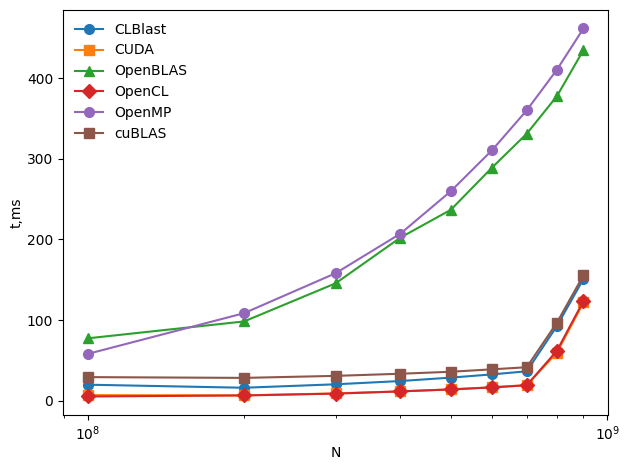

In [7]:
float_tests_df = float_tests_df[float_tests_df["runtime"] != "C++"]
float_tests_df = float_tests_df[float_tests_df["runtime"] != "C++*"]

plot_metrics(float_tests_df)

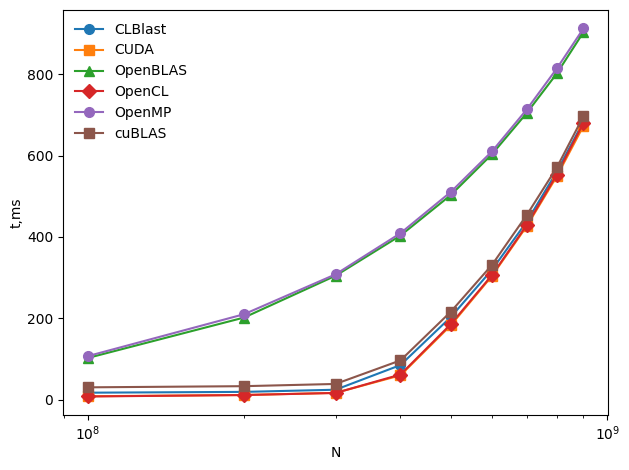

In [8]:
double_tests_df = double_tests_df[double_tests_df["runtime"] != "C++"]
double_tests_df = double_tests_df[double_tests_df["runtime"] != "C++*"]

plot_metrics(double_tests_df)

In [9]:
float_tests = [{"size": v["rows"],**v["tests"][0]} for v in metrics if v["type"] == "float" and "rows" in v]
float_tests_df = pd.DataFrame(float_tests)
float_tests_df = float_tests_df.sort_values("duration", ascending=True)

double_tests = [{"size": v["rows"],**v["tests"][0]} for v in metrics if v["type"] == "double" and "rows" in v]
double_tests_df = pd.DataFrame(double_tests)
double_tests_df = double_tests_df.sort_values("duration", ascending=True)

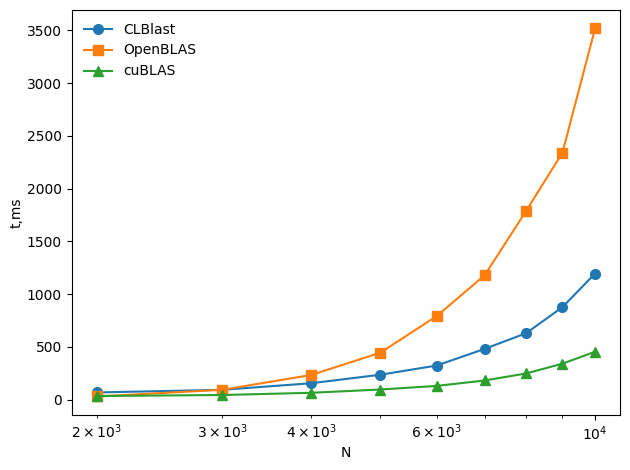

In [10]:
float_tests_df = float_tests_df[float_tests_df["runtime"] != "C++"]
float_tests_df = float_tests_df[float_tests_df["runtime"] != "C++*"]

plot_metrics(float_tests_df)

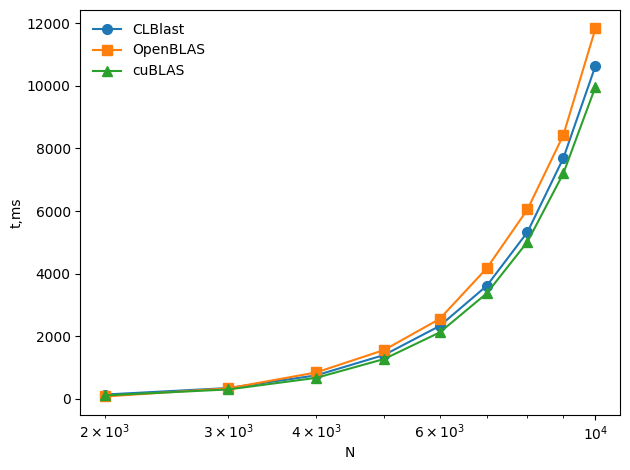

In [11]:
double_tests_df = double_tests_df[double_tests_df["runtime"] != "C++"]
double_tests_df = double_tests_df[double_tests_df["runtime"] != "C++*"]

plot_metrics(double_tests_df)